In [2]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import warnings
from scipy.spatial.distance import cdist
import pynndescent
from scipy.sparse import csr_matrix, issparse
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import coo_matrix

from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from numpy.linalg import eig, inv, pinv, eigvals
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from scipy.sparse import csr_matrix, random as sparse_random, find, issparse
from scipy.sparse.linalg import svds
from scipy.linalg import eigh
from scipy.sparse.linalg import eigs

from scipy.optimize import minimize
from scipy.stats import multivariate_normal as mvnpdf
import cvxpy as cp
import time
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import precision_recall_curve
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from numpy.matlib import repmat
import scipy.sparse as sp
import jax.numpy as jnp
from scipy.stats import boxcox
from scipy.sparse import issparse, csr_matrix

from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [5]:
def squareform_sp(w):
    """
    Sparse counterpart of numpy's squareform
    
    Parameters:
    w : sparse vector with n(n-1)/2 elements OR matrix with size [n, n] and zero diagonal
    
    Returns:
    W : matrix form of input vector w OR vector form of input matrix W
    """
    # If input is not sparse, check density
    if not sp.issparse(w):
        density = np.count_nonzero(w) / w.size
        if density > 1/10:
            # Use standard squareform for non-sparse data
            return squareform(w)
        else:
            # Proceed with the function using NumPy arrays
            pass
    
    if w.ndim == 1 or w.shape[0] == 1 or w.shape[1] == 1:  # It's a vector
        # VECTOR -> MATRIX
        l = w.size
        n = int(round((1 + np.sqrt(1 + 8*l)) / 2))
        
        # Check input
        if l != n*(n-1)//2:
            raise ValueError("Bad vector size!")
        
        ind_vec = w.nonzero()[0]
        s = w[ind_vec]
        num_nz = len(ind_vec)
        
        ind_i = np.zeros(num_nz, dtype=int)
        ind_j = np.zeros(num_nz, dtype=int)
        
        curr_row = 0
        offset = 0
        len_row = n - 1
        for idx in range(num_nz):
            ind_vec_i = ind_vec[idx]
            while ind_vec_i >= (len_row + offset):
                offset += len_row
                len_row -= 1
                curr_row += 1
            ind_i[idx] = curr_row
            ind_j[idx] = ind_vec_i - offset + curr_row + 1
        
        # For the lower triangular part just add the transposed matrix
        data = np.concatenate([s, s])
        row_indices = np.concatenate([ind_i, ind_j])
        col_indices = np.concatenate([ind_j, ind_i])
        W = sp.csr_matrix((data, (row_indices, col_indices)), shape=(n, n))
        return W

    else:
        # MATRIX -> VECTOR
        m, n = w.shape
        if m != n or not np.all(np.diagonal(w) == 0):
            raise ValueError("Matrix has to be square with zero diagonal!")
        
        ind_i, ind_j = w.nonzero()
        s = w[ind_i, ind_j]
        
        # Keep only upper triangular part
        ind_upper = ind_i < ind_j
        ind_i = ind_i[ind_upper]
        ind_j = ind_j[ind_upper]
        s = s[ind_upper]
        
        # Compute new (vector) index from (i,j) (matrix) indices
        new_ind = n * ind_i - ind_i * (ind_i + 1) // 2 + ind_j - ind_i - 1
        l = n * (n - 1) // 2
        w_vec = sp.csr_matrix((s, (new_ind, np.zeros_like(new_ind))), shape=(l, 1))
        return w_vec

def sum_squareform(n, mask=None):
    """
    Computes the sum and transpose sum matrices in a squareform format.

    Parameters:
    -----------
    n : int
        The size of the squareform matrix.
    
    mask : array-like, optional
        A mask to filter the indices. The length of the mask must be n(n-1)/2.
        If provided, only the elements corresponding to the non-zero values in
        the mask are considered.

    Returns:
    --------
    S : csr_matrix
        A sparse matrix so that S * w = sum(W), where w = squareform(W)
    
    St : csr_matrix
        The adjoint of S.

    Raises:
    -------
    ValueError
        If the length of the mask is not equal to n(n-1)/2.
    """
    if mask is not None:
        mask = np.asarray(mask).flatten()
        if len(mask) != n * (n - 1) // 2:
            raise ValueError('Mask size has to be n(n-1)/2')

        ind_vec = np.flatnonzero(mask)
        ncols = len(ind_vec)

        I = np.zeros(ncols, dtype=int)
        J = np.zeros(ncols, dtype=int)

        curr_row = 0
        offset = 0
        len_row = n - 1
        for ii in range(ncols):
            ind_vec_i = ind_vec[ii]
            while ind_vec_i > (len_row + offset - 1):
                offset += len_row
                len_row -= 1
                curr_row += 1
            I[ii] = curr_row
            J[ii] = ind_vec_i - offset + curr_row + 1
    else:
        ncols = n * (n - 1) // 2
        I = np.zeros(ncols, dtype=int)
        J = np.zeros(ncols, dtype=int)

        k = 0
        for i in range(n - 1):
            for j in range(i + 1, n):
                I[k] = i
                J[k] = j
                k += 1

    # Construct St
    row_indices = np.concatenate([np.arange(ncols), np.arange(ncols)])
    col_indices = np.concatenate([I, J])
    data = np.ones(2 * ncols)

    St = csr_matrix((data, (row_indices, col_indices)), shape=(ncols, n))
    S = St.transpose()

    return S, St


def normest(S):
    """
    Estimate the 2-norm (largest singular value) of a sparse matrix S.
    """
    u, s, vt = svds(S, k=1)
    return s[0]


def prox_sum_log(x, gamma, param=None):
    """
    Proximal operator of log-barrier - sum(log(x))
    
    Solves:
        sol = argmin_{z} 0.5*||x - z||_2^2 - gamma * sum(log(z))
    
    Parameters:
    ----------
    x : array-like
        Input signal (vector or matrix).
    gamma : float
        Regularization parameter.
    param : dict, optional
        Dictionary of optional parameters:
        - 'verbose': int, verbosity level (default: 1).
    
    Returns:
    -------
    sol : numpy.ndarray
        Solution to the optimization problem.
    info : dict
        Dictionary summarizing information at convergence.
    """
    if param is None:
        param = {}
    
    verbose = param.get('verbose', 1)
    
    if gamma < 0:
        raise ValueError('Gamma cannot be negative')
    elif gamma == 0:
        stop_error = True
    else:
        stop_error = False
    
    t1 = time.time()
    
    if stop_error:
        sol = x
        info = {
            'algo': 'prox_sum_log',
            'iter': 0,
            'final_eval': 0,
            'crit': '--',
            'time': time.time() - t1
        }
        return sol, info
    
    # Compute the solution
    sol = (x + np.sqrt(x**2 + 4*gamma)) / 2
    
    # Compute the final evaluation of the function
    final_eval = -gamma * np.sum(np.log(x.flatten()))
    
    info = {
        'algo': 'prox_sum_log',
        'iter': 0,
        'final_eval': final_eval,
        'crit': '--',
        'time': time.time() - t1
    }
    
    # Verbose output
    if verbose >= 1:
        print(f'  prox_sum_log: - sum(log(x)) = {info["final_eval"] / gamma:.6e}')
        if verbose > 1:
            n_neg = np.sum(x.flatten() <= 0)
            if n_neg > 0:
                print(f' ({n_neg} negative elements, log not defined, check stability)')
        print()
    
    return sol, info




def lin_map(X, lims_out, lims_in=None):
    """
    Map linearly from a given range to another.

    Parameters:
    X : array-like
        Input array.
    lims_out : list or tuple
        Output limits [c, d].
    lims_in : list or tuple, optional
        Input limits [a, b]. If not specified, the minimum and maximum values of X are used.

    Returns:
    Y : array-like
        Linearly mapped output array.
    """
    X = np.asarray(X)
    
    if lims_in is None:
        lims_in = [np.min(X), np.max(X)]
    
    a, b = lims_in
    c, d = lims_out
    
    Y = (X - a) * ((d - c) / (b - a)) + c
    return Y



def gsp_distanz(X, Y=None, P=None):
    """
    Calculates the distances between all vectors in X and Y using a provided matrix P for scaling (weighted distances).
    
    Parameters:
        X (numpy.ndarray): Matrix with column vectors of shape (n_features, n_samples_X).
        Y (numpy.ndarray, optional): Matrix with column vectors of shape (n_features, n_samples_Y). Defaults to X.
        P (numpy.ndarray, optional): Weight matrix of shape (n_features, n_features). Defaults to the identity matrix.

    Returns:
        numpy.ndarray: Distance matrix of shape (n_samples_X, n_samples_Y), not squared.
        
    Raises:
        ValueError: If the dimensions of X and Y do not match.
        ValueError: If the dimensions of P do not match the number of features in X.

    Usage:
        D = gsp_distanz(X, Y, P)
        
    Notes:
        This function computes the following:
        
            D = sqrt((X - Y)^T P (X - Y))
        
        for all vectors in X and Y. If P is not provided, it defaults to the identity matrix, reducing the calculation to the Euclidean distance.
        The function is optimized for speed using vectorized operations, avoiding explicit loops.
    """
    
    if Y is None:
        Y = X
    
    if X.shape[0] != Y.shape[0]:
        raise ValueError("The sizes of X and Y do not match!")

    n_features, n_samples_X = X.shape
    _, n_samples_Y = Y.shape
    
    if P is None:
        xx = np.sum(X**2, axis=0)  # ||x||^2
        yy = np.sum(Y**2, axis=0)  # ||y||^2
        xy = X.T @ Y  # <y,x>
        D = np.abs(np.add.outer(xx, yy) - 2 * xy)
    else:
        rp, rp2 = P.shape
        if n_features != rp or rp != rp2:
            raise ValueError("P must be square and match the dimension of X!")

        xx = np.sum(X * (P @ X), axis=0)  # x^T P x
        yy = np.sum(Y * (P @ Y), axis=0)  # y^T P y
        xy = X.T @ (P @ Y)  # x^T P y
        D = np.abs(np.add.outer(xx, yy) - 2 * xy)
    
    if np.any(D < 0):
        print('Warning: P is not semipositive or x is not real!')

    D = np.sqrt(D)
    
    if Y is X:
        np.fill_diagonal(D, 0)

    return D

# Example usage
def generate_example_data(n=256):
    G_coords = np.random.rand(n, 2)
    f1 = lambda x, y: np.sin((2 - x - y) ** 2)
    f2 = lambda x, y: np.cos((x + y) ** 2)
    f3 = lambda x, y: (x - 0.5) ** 2 + (y - 0.5) ** 3 + x - y
    f4 = lambda x, y: np.sin(3 * ((x - 0.5) ** 2 + (y - 0.5) ** 2))
    X = np.vstack([f1(G_coords[:, 0], G_coords[:, 1]),
                   f2(G_coords[:, 0], G_coords[:, 1]),
                   f3(G_coords[:, 0], G_coords[:, 1]),
                   f4(G_coords[:, 0], G_coords[:, 1])]).T
    return G_coords, X


def visualize_glmm(Ls, gamma_hats):
    k = gamma_hats.shape[1]
    n = Ls.shape[0]
    
    G = nx.Graph()
    
    for i in range(n):
        G.add_node(i)
    
    for l in range(k):
        L = Ls[:, :, l]
        for i in range(n):
            for j in range(i+1, n):
                if L[i, j] != 0:
                    G.add_edge(i, j, weight=L[i, j])
    
    colors = []
    for i in range(n):
        cluster = np.argmax(gamma_hats[i])
        colors.append(cluster)
    
    pos = nx.spring_layout(G)  
    
    nx.draw_networkx_nodes(G, pos, node_size=700, cmap=plt.cm.RdYlBu, node_color=colors)
    
    edges = G.edges(data=True)
    weights = [edata['weight'] for _, _, edata in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights)
    
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
    
    plt.title('Graph Laplacian Mixture Model (GLMM) Visualization')
    plt.show()
    
    
    
def gsp_learn_graph_log_degrees(Z, a, b, params=None):
    """
    Learns a graph structure by optimizing a log-degrees model.

    Parameters:
    -----------
    Z : array-like
        Input data matrix or condensed distance matrix.

    a : float
        Coefficient for the logarithmic penalty term.

    b : float
        Regularization coefficient.

    params : dict, optional
        A dictionary of optional parameters:
        - 'W_init': Initial weight matrix (default: zeros)
        - 'verbosity': int, level of verbosity (default: 1)
        - 'maxit': int, maximum number of iterations (default: 1000)
        - 'tol': float, tolerance for convergence (default: 1e-5)
        - 'step_size': float, step size for the gradient descent (default: 0.5)
        - 'max_w': float, maximum allowable weight (default: np.inf)
        - 'w_0': array-like or int, initial weight matrix or value (default: 0)
        - 'c': float, regularization coefficient for initial weight matrix
        - 'fix_zeros': bool, whether to fix zeros in the weight matrix (default: False)
        - 'edge_mask': array-like, mask for fixed edges (required if 'fix_zeros' is True)

    Returns:
    --------
    W : array-like
        The learned weight matrix.

    stat : dict
        Optional output statistics.

    Raises:
    -------
    ValueError
        If 'params.w_0' is specified but 'params.c' is not, or if 'params.edge_mask' is required but not provided.
    """
    # Default parameters
    if params is None:
        params = {}

    verbosity = params.get('verbosity', 1)
    maxit = params.get('maxit', 1000)
    tol = params.get('tol', 1e-5)
    step_size = params.get('step_size', 0.5)
    fix_zeros = params.get('fix_zeros', False)
    max_w = params.get('max_w', np.inf)
    w_0 = params.get('w_0', 0)

    # Initialize z
    if isinstance(Z, np.ndarray) and Z.ndim == 1:
        z = Z.copy()
    else:
        z = squareform_sp(Z)

    z = z.flatten()
    l = len(z)
    n = int(round((1 + np.sqrt(1 + 8 * l)) / 2))  # Number of nodes

    # Handle w_0
    if not np.isscalar(w_0) or w_0 != 0:
        if 'c' not in params:
            raise ValueError('When params["w_0"] is specified, params["c"] should also be specified.')
        else:
            c = params['c']
        if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
            w_0 = w_0.copy()
        else:
            w_0 = squareform_sp(w_0)
        w_0 = w_0.flatten()
    else:
        w_0 = 0

    # Handle fix_zeros
    if fix_zeros:
        if 'edge_mask' not in params:
            raise ValueError('When params["fix_zeros"] is True, params["edge_mask"] must be provided.')
        edge_mask = params['edge_mask']
        if not isinstance(edge_mask, np.ndarray) or edge_mask.ndim != 1:
            edge_mask = squareform_sp(edge_mask)
        ind = np.nonzero(edge_mask.flatten())[0]
        z = z[ind]
        if not np.isscalar(w_0):
            w_0 = w_0[ind]
    else:
        edge_mask = None

    # Initialize w
    w = np.zeros_like(z)

    # Needed operators
    if fix_zeros:
        S, St = sum_squareform(n, edge_mask)
    else:
        S, St = sum_squareform(n)

    K_op = lambda w: S @ w
    Kt_op = lambda z: St @ z

    if fix_zeros:
        norm_K = normest(S)
    else:
        norm_K = np.sqrt(2 * (n - 1))

    # Define functions f, g, h
    f_eval = lambda w: 2 * np.dot(w, z)
    f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

    param_prox_log = {'verbose': verbosity - 3}
    g_eval = lambda s: -a * np.sum(np.log(s))
    g_prox = lambda s, c: prox_sum_log(s, c * a, param_prox_log)[0]
    g_star_prox = lambda z, c: z - c * a * prox_sum_log(z / (c * a), 1 / (c * a), param_prox_log)[0]

    if np.all(w_0 == 0):
        h_eval = lambda w: b * np.linalg.norm(w) ** 2
        h_grad = lambda w: 2 * b * w
        h_beta = 2 * b
    else:
        h_eval = lambda w: b * np.linalg.norm(w) ** 2 + c * np.linalg.norm(w - w_0) ** 2
        h_grad = lambda w: 2 * ((b + c) * w - c * w_0)
        h_beta = 2 * (b + c)

    # Parameters for convergence
    mu = h_beta + norm_K
    epsilon = 1e-6  # A small positive value
    gn = (1 - epsilon) / mu  # Step size in (epsilon, (1 - epsilon)/mu)

    # Initialize variables
    v_n = K_op(w)

    stat = {}
    if verbosity > 1:
        stat['f_eval'] = []
        stat['g_eval'] = []
        stat['h_eval'] = []
        stat['fgh_eval'] = []
        stat['pos_violation'] = []

    start_time = time.time()

    # Iterative optimization
    for i in range(maxit):
        # Primal and dual updates
        Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
        y_n = v_n + gn * K_op(w)
        P_n = f_prox(Y_n, gn)
        p_n = g_star_prox(y_n, gn)
        Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
        q_n = p_n + gn * K_op(P_n)

        # Compute relative norms
        rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)
        rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)

        if verbosity > 1:
            # Record statistics
            stat['f_eval'].append(f_eval(w))
            stat['g_eval'].append(g_eval(K_op(w)))
            stat['h_eval'].append(h_eval(w))
            stat['fgh_eval'].append(stat['f_eval'][-1] + stat['g_eval'][-1] + stat['h_eval'][-1])
            stat['pos_violation'].append(-np.sum(np.minimum(0, w)))
            print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   OBJ {stat["fgh_eval"][-1]:6.3e}')

        # Update variables
        w = w - Y_n + Q_n
        v_n = v_n - y_n + q_n

        # Check convergence
        if rel_norm_primal < tol and rel_norm_dual < tol:
            break

    total_time = time.time() - start_time
    if verbosity > 0:
        print(f'# iters: {i+1:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e}  OBJ {f_eval(w) + g_eval(K_op(w)) + h_eval(w):6.3e}')
        print(f'Time needed is {total_time} seconds')

    # Reconstruct full weight vector if fix_zeros was used
    if fix_zeros:
        w_full = np.zeros(l)
        w_full[ind] = w
        w = w_full

    # Convert vectorized weights back to matrix form
    if isinstance(Z, np.ndarray) and Z.ndim == 1:
        W = w
    else:
        W = squareform_sp(w)

    stat['time'] = total_time

    return W, stat


In [6]:

def gsp_plot_edges(G, param=None):
    """
    Plot the edges of the graph G.

    Parameters:
        G (dict): Graph structure with 'W', 'coords', 'directed', and 'plotting' keys.
        param (dict, optional): Optional parameters.

    The function uses the adjacency matrix 'G['W']', node coordinates 'G['coords']',
    and plotting parameters in 'G['plotting']' to plot the edges of the graph.

    Additional parameters:
    - param['edge_size']: If set to True (non-zero), edges are plotted with varying sizes
                          based on the weights in 'G['W']'. Default is False.
    """

    if param is None:
        param = {}

    if 'edge_size' not in param:
        param['edge_size'] = 0  # Default value

    W = G['W']
    coords = G['coords']
    directed = G.get('directed', False)
    plotting = G.get('plotting', {})

    edge_style = plotting.get('edge_style', '-')
    edge_width = plotting.get('edge_width', 1)
    edge_color = plotting.get('edge_color', 'k')  # Default color black

    # Find indices of non-zero entries in W
    if hasattr(W, 'nonzero'):
        ki, kj = W.nonzero()
    else:
        ki, kj = np.nonzero(W)

    ki = np.array(ki)
    kj = np.array(kj)

    if directed:
        if coords.shape[1] == 2:
            In = coords[ki, :]  # Starting points
            Fin = coords[kj, :]  # Ending points
            V = Fin - In  # Vectors from In to Fin

            plt.quiver(In[:, 0], In[:, 1], V[:, 0], V[:, 1],
                       angles='xy', scale_units='xy', scale=1,
                       color=edge_color, linewidth=edge_width,
                       linestyle=edge_style)
        elif coords.shape[1] == 3:
            In = coords[ki, :]  # Starting points
            Fin = coords[kj, :]  # Ending points
            V = Fin - In  # Vectors from In to Fin

            ax = plt.gca(projection='3d')
            ax.quiver(In[:, 0], In[:, 1], In[:, 2],
                      V[:, 0], V[:, 1], V[:, 2],
                      length=1, normalize=False,
                      color=edge_color, linewidth=edge_width,
                      linestyle=edge_style)
    else:
        if param['edge_size']:
            if len(ki) > 1000:
                print('Plotting edges with different sizes. It may take some time.')

            if coords.shape[1] == 2:
                for ii in range(len(ki)):
                    x = [coords[ki[ii], 0], coords[kj[ii], 0]]
                    y = [coords[ki[ii], 1], coords[kj[ii], 1]]
                    # Calculate linewidth based on edge weight
                    lw = edge_width * (3 * W[ki[ii], kj[ii]] + 0.01)
                    plt.plot(x, y, edge_style, linewidth=lw, color=edge_color)
            elif coords.shape[1] == 3:
                ax = plt.gca(projection='3d')
                for ii in range(len(ki)):
                    x = [coords[ki[ii], 0], coords[kj[ii], 0]]
                    y = [coords[ki[ii], 1], coords[kj[ii], 1]]
                    z = [coords[ki[ii], 2], coords[kj[ii], 2]]
                    lw = edge_width * (3 * W[ki[ii], kj[ii]] + 0.01)
                    ax.plot(x, y, z, edge_style, linewidth=lw, color=edge_color)
        else:
            if coords.shape[1] == 2:
                x = np.vstack((coords[ki, 0], coords[kj, 0]))
                y = np.vstack((coords[ki, 1], coords[kj, 1]))
                plt.plot(x, y, edge_style, linewidth=edge_width, color=edge_color)
            elif coords.shape[1] == 3:
                x = np.vstack((coords[ki, 0], coords[kj, 0]))
                y = np.vstack((coords[ki, 1], coords[kj, 1]))
                z = np.vstack((coords[ki, 2], coords[kj, 2]))
                ax = plt.gca(projection='3d')
                ax.plot(x, y, z, edge_style, linewidth=edge_width, color=edge_color)
                
                
def gsp_isdirected(G):
    """
    GSP_ISDIRECTED Check if the graph is directed.

    Usage:
        bool = gsp_isdirected(G)
        bool = gsp_isdirected(W)

    Input parameters:
        G : Graph structure (dictionary) or square matrix (NumPy array or SciPy sparse matrix)

    Output parameters:
        bool : Boolean
            - Returns False if the matrix is symmetric (graph is undirected)
            - Returns True if the matrix is not symmetric (graph is directed)

    This function tests if the graph is directed. Alternatively, you can
    provide a square matrix, and it tests if it is symmetric within numerical tolerance.
    The function returns False if the matrix is symmetric and True otherwise.
    """

    # Check if G is a graph structure (dictionary) or a matrix
    if isinstance(G, dict):
        W = G['W']
    else:
        W = G

    # Numerical tolerance
    epsilon = np.finfo(float).eps * 10

    # For sparse matrices
    if issparse(W):
        # Ensure W is in CSR format for efficient arithmetic operations
        W = W.tocsr()
        W_transpose = W.transpose().tocsr()

        # Compute the difference matrix
        diff = W - W_transpose

        # Take the absolute value of the differences
        abs_diff = diff.copy()
        abs_diff.data = np.abs(abs_diff.data)

        # Zero out elements below the tolerance
        abs_diff.data[abs_diff.data <= epsilon] = 0

        # Eliminate zero entries
        abs_diff.eliminate_zeros()

        # Check if any non-zero entries remain
        is_directed = abs_diff.nnz > 0

    # For dense matrices
    else:
        W = np.array(W)
        # Compute the absolute difference matrix
        abs_diff = np.abs(W - W.T)

        # Check if any elements exceed the tolerance
        is_directed = np.any(abs_diff > epsilon)

    return is_directed



def gsp_check_weights(W):
    """
    Check a weight matrix.

    Parameters:
        W : numpy.ndarray or scipy.sparse matrix
            Weight matrix

    Returns:
        a : int
            Warning code

    This function performs various tests on the weight matrix W. It returns:

        * 0 : Everything is ok
        * 1 : The matrix contains infinite values
        * 2 : The diagonal is not zero
        * 3 : The matrix is not square
        * 4 : The matrix contains NaN values
    """

    a = 0

    # Check for infinite values
    if sparse.issparse(W):
        data = W.data
        if np.isinf(data).sum() > 0:
            warnings.warn('GSP_CHECK_WEIGHTS: There is an infinite value in the weight matrix')
            a = 1
    else:
        if np.isinf(W).sum() > 0:
            warnings.warn('GSP_CHECK_WEIGHTS: There is an infinite value in the weight matrix')
            a = 1

    # Check if the diagonal is not zero
    if sparse.issparse(W):
        diag_W = W.diagonal()
    else:
        diag_W = np.diag(W)
    if np.abs(diag_W).sum() > 0:
        print('GSP_CHECK_WEIGHTS: The diagonal of the weight matrix is not zero!')
        a = 2

    # Check if W is square
    if W.shape[0] != W.shape[1]:
        warnings.warn('GSP_CHECK_WEIGHTS: The weight matrix is not square!')
        a = 3

    # Check for NaN values
    if sparse.issparse(W):
        data = W.data
        if np.isnan(data).sum() > 0:
            warnings.warn('GSP_CHECK_WEIGHTS: There is a NaN value in the weight matrix')
            a = 4
    else:
        if np.isnan(W).sum() > 0:
            warnings.warn('GSP_CHECK_WEIGHTS: There is a NaN value in the weight matrix')
            a = 4

    return a

def gsp_graph_default_plotting_parameters(G):
    """
    Complete all plotting parameters for a graph.

    Parameters:
        G (dict): Graph structure.

    Returns:
        dict: Graph structure with plotting parameters filled in.

    This function fills in missing plotting parameters in the graph structure `G`.
    It ensures that the graph has all the necessary attributes for plotting.

    List of plotting parameters:
        - G['plotting']: Plotting parameters dictionary
            - G['plotting']['edge_width']: Width of edges (default 1)
            - G['plotting']['edge_color']: Color of edges (default [0.6, 0.6, 0.6])
            - G['plotting']['edge_style']: Style of edges (default '-')
            - G['plotting']['vertex_size']: Size of vertices (default 50)
            - G['plotting']['vertex_color']: Color of vertices (default 'b')
            - G['plotting']['limits']: Axis limits for plotting
    """
    if G is None:
        raise ValueError('You need a graph to run this function!')

    if 'coords' in G and G['coords'] is not None:

        # Assign default plotting parameters
        if 'plotting' not in G or G['plotting'] is None:
            G['plotting'] = {}

        plotting = G['plotting']

        if 'edge_width' not in plotting:
            plotting['edge_width'] = 1
        if 'edge_color' not in plotting:
            plotting['edge_color'] = [0.6, 0.6, 0.6]  # Equivalent to [0.6, 0.6, 0.6]
        if 'edge_style' not in plotting:
            plotting['edge_style'] = '-'
        if 'vertex_size' not in plotting:
            plotting['vertex_size'] = 50
        if 'vertex_color' not in plotting:
            plotting['vertex_color'] = 'b'

        # Limits for plotting
        if 'limits' not in plotting:
            coords = G['coords']
            if coords.shape[1] > 2:
                # 3D coordinates
                mrx = (np.max(coords[:, 0]) - np.min(coords[:, 0])) / 20 + np.finfo(float).eps
                mry = (np.max(coords[:, 1]) - np.min(coords[:, 1])) / 20 + np.finfo(float).eps
                mrz = (np.max(coords[:, 2]) - np.min(coords[:, 2])) / 20 + np.finfo(float).eps
                plotting['limits'] = [
                    np.min(coords[:, 0]) - mrx, np.max(coords[:, 0]) + mrx,
                    np.min(coords[:, 1]) - mry, np.max(coords[:, 1]) + mry,
                    np.min(coords[:, 2]) - mrz, np.max(coords[:, 2]) + mrz
                ]
            elif coords.shape[1] > 1:
                # 2D coordinates
                mrx = (np.max(coords[:, 0]) - np.min(coords[:, 0])) / 20 + np.finfo(float).eps
                mry = (np.max(coords[:, 1]) - np.min(coords[:, 1])) / 20 + np.finfo(float).eps
                plotting['limits'] = [
                    np.min(coords[:, 0]) - mrx, np.max(coords[:, 0]) + mrx,
                    np.min(coords[:, 1]) - mry, np.max(coords[:, 1]) + mry
                ]
            else:
                # 1D coordinates
                mrx = (np.max(coords) - np.min(coords)) / 20
                plotting['limits'] = [np.min(coords) - mrx, np.max(coords) + mrx]
        G['plotting'] = plotting
    else:
        G['plotting'] = {}

    return G

def gsp_graph_default_parameters(G=None):
    """
    Load default parameters for a graph.

    Parameters:
        G (dict, optional): Graph structure represented as a dictionary.
                            If None, an empty graph is created.

    Returns:
        G (dict): Graph structure with default parameters filled in.

    This function fills a graph with all missing parameters to make
    it compatible with graph signal processing functions. If you create a
    graph manually, you need to set only the weight matrix 'W'. If you have
    some coordinates, you can also set 'G['coords']'. 'G['coords']' is an
    array of shape (N, 2) or (N, 3) where each column represents a coordinate
    in each dimension. Finally, we recommend setting the field 'G['type']'
    with a name that suits your graph.

    Example:

        import numpy as np
        from scipy.sparse import csr_matrix

        W = np.random.rand(30, 30)
        W = (W + W.T) / 2
        W = W - np.diag(np.diag(W))
        G = {'W': csr_matrix(W)}
        G = gsp_graph_default_parameters(G)

    This function can be used to update the weights of your graph. It will
    recompute the Laplacian operator. Warning: this function does not
    perform any change to the Fourier basis.

        W_new = ... # Your new weight matrix
        G['W'] = csr_matrix(W_new)
        G = gsp_graph_default_parameters(G)
    """

    if G is None:
        G = {}

    # Weight matrix 'W'
    if 'W' not in G or G['W'] is None:
        G['W'] = csr_matrix((0, 0))
    else:
        if not issparse(G['W']):
            G['W'] = csr_matrix(G['W'])

    # Adjacency matrix 'A' (constructed from 'W')
    G['A'] = (G['W'] > 0).astype(int)
    if not issparse(G['A']):
        G['A'] = csr_matrix(G['A'])

    # Number of nodes 'N'
    G['N'] = G['W'].shape[0]

    # Type of graph
    if 'type' not in G:
        G['type'] = 'unknown'

    # Directed or undirected graph
    # Check if 'directed' field exists; if not, compute it
    G['directed'] = gsp_isdirected(G)

    # Hypergraph indicator
    if 'hypergraph' not in G:
        G['hypergraph'] = False

    # Laplacian type
    if 'lap_type' not in G:
        G['lap_type'] = 'combinatorial'

    # Create the graph Laplacian
    # G = gsp_create_laplacian(G)

    # Degree vector 'd'
    G['d'] = np.array(G['W'].sum(axis=1)).flatten()

    # Number of edges 'Ne'
    if G['directed']:
        G['Ne'] = G['W'].nnz
    else:
        G['Ne'] = G['W'].nnz // 2

    # Coordinates 'coords'
    if 'coords' not in G:
        G['coords'] = None  # Or an empty array: np.array([])

    # Plotting parameters
    G = gsp_graph_default_plotting_parameters(G)

    return G

def gsp_plot_graph(G, param=None):
    """
    Plot a graph in 2D or 3D.

    Parameters:
        G (dict or list): Graph structure or a list of graph structures.
        param (dict, optional): Optional parameters.

    The function uses the adjacency matrix (G['A']), plotting coordinates (G['coords']),
    and various plotting parameters in G['plotting'] to plot the graph.

    Additional parameters:
    - param['show_edges']: Set to 0 to only draw the vertices (default: G['Ne'] < 10000).
    - param['num_clusters']: Number of clusters for a clustered graph.
    - param['clusters']: Cluster identities for a clustered graph.
    - param['cluster_colors']: Cluster colors for a clustered graph.
    - param['cp']: Camera position for a 3D graph.
    """

    # Handle optional inputs
    if param is None:
        param = {}

    if 'coords' not in G or G['coords'] is None:
        raise ValueError('There are no coordinates associated with this graph!')

    if 'show_edges' not in param:
        param['show_edges'] = G.get('Ne', 0) < 10000

    if 'clear' not in param:
        param['clear'] = True

    if 'edge_size' not in param:
        param['edge_size'] = 0

    # Check if G is a list of graphs
    if isinstance(G, list):
        for g in G:
            plt.figure()
            gsp_plot_graph(g, param)
    else:
        # Clear figure if required
        if param.get('clear', True):
            plt.clf()

        G = gsp_graph_default_plotting_parameters(G)

        # Handle clusters
        if ('num_clusters' not in param or
            'clusters' not in param or
            'cluster_colors' not in param):
            num_clusters = 1
            clusters = np.ones(G['N'], dtype=int)
            cluster_colors = np.array([G['plotting']['vertex_color']])
        else:
            num_clusters = param['num_clusters']
            clusters = param['clusters']
            cluster_colors = param['cluster_colors']
            if len(cluster_colors) < num_clusters:
                raise ValueError('Not enough cluster colors specified')

        # Set up the plot
        fig = plt.gcf()
        if G['coords'].shape[1] == 3:
            ax = fig.add_subplot(111, projection='3d')
        else:
            ax = fig.add_subplot(111)

        # Plot edges if required
        if param['show_edges']:
            
            
            (G, param)

        # Plot vertices
        for i in range(num_clusters):
            cluster_indices = np.where(clusters == (i + 1))[0]  # Adjust for 0-based indexing
            coords = G['coords'][cluster_indices, :]

            if G['coords'].shape[1] == 2:
                ax.scatter(coords[:, 0], coords[:, 1],
                           s=G['plotting']['vertex_size'],
                           c=[cluster_colors[i]],
                           edgecolors=G['plotting']['vertex_color'])
            elif G['coords'].shape[1] == 3:
                ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                           s=G['plotting']['vertex_size'],
                           c=[cluster_colors[i]],
                           edgecolors=G['plotting']['vertex_color'])

        # Set axis limits
        if G['plotting']['limits'] is not None:
            ax.axis(G['plotting']['limits'])
        else:
            ax.autoscale()

        # Set camera position for 3D plots
        if G['coords'].shape[1] == 3:
            if 'cp' not in param:
                cp = [-1.4, -16.9, 3.4]
            else:
                cp = param['cp']
            ax.view_init(elev=cp[2], azim=cp[0])

        plt.axis('off')
        plt.show()
        
def gsp_graph(W, coords=None, limits=None):
    """
    Create a graph given a weighted adjacency matrix.

    Usage:
        G = gsp_graph(W)
        G = gsp_graph(W, coords)
        G = gsp_graph(W, coords, limits)

    Input parameters:
        W      : (n x n) Weighted adjacency matrix
        coords : (n x 2) or (n x 3) Coordinates of the points (optional)
        limits : Limits for the coordinates (optional)

    Output parameters:
        G      : Graph structure as a dictionary.

    'gsp_graph(W, coords, limits)' initializes a graph structure with W as
    the weight matrix.

    Example:

        import numpy as np
        W = np.random.rand(10, 10)
        W = W - np.diag(np.diag(W))
        W = (W + W.T) / 2
        G = gsp_graph(W)
    """

    # Ensure W is a NumPy array or SciPy sparse matrix
    if not isinstance(W, (np.ndarray, csr_matrix)):
        raise ValueError("W must be a NumPy array or SciPy sparse matrix")

    # Convert W to a sparse matrix if it's not already
    if isinstance(W, np.ndarray):
        W = csr_matrix(W)

    # Check the weight matrix for issues
    a = gsp_check_weights(W)
    if a != 0:
        warnings.warn(f"Weight matrix check returned warning code: {a}")

    # Initialize the graph structure as a dictionary
    G = {}

    # Assign the weight matrix to the graph
    G['W'] = W

    # Assign coordinates if provided
    if coords is not None:
        G['coords'] = np.array(coords)
        if G['coords'].shape[0] != W.shape[0]:
            raise ValueError("The number of coordinates does not match the number of nodes in W")

    # Assign plotting limits if provided
    if limits is not None:
        if 'plotting' not in G or G['plotting'] is None:
            G['plotting'] = {}
        G['plotting']['limits'] = limits

    # Set the graph type
    G['type'] = 'from weight'

    # Set default parameters for the graph
    G = gsp_graph_default_parameters(G)

    return G

def gsp_2dgrid(N=16, M=None):
    """
    Initialize a 2-dimensional grid graph.

    Parameters:
        N (int): Number of vertices along the first dimension (default 16).
        M (int, optional): Number of vertices along the second dimension. Defaults to N.

    Returns:
        G (dict): Graph structure with adjacency matrix, coordinates, and plotting parameters.

    Example:

        G = gsp_2dgrid(16)
        param = {'show_edges': 1}
        gsp_plot_graph(G, param)

    """

    if M is None:
        M = N

    G = {}
    G['N'] = N * M

    # Create weighted adjacency matrix
    i_inds = []
    j_inds = []

    # Connect horizontal edges
    for m in range(M):
        for n in range(N):
            node = m * N + n
            # Connect to right neighbor
            if n < N - 1:
                right_node = m * N + (n + 1)
                i_inds.extend([node, right_node])
                j_inds.extend([right_node, node])

    # Connect vertical edges
    for m in range(M):
        for n in range(N):
            node = m * N + n
            # Connect to bottom neighbor
            if m < M - 1:
                bottom_node = (m + 1) * N + n
                i_inds.extend([node, bottom_node])
                j_inds.extend([bottom_node, node])

    data = np.ones(len(i_inds))
    W = coo_matrix((data, (i_inds, j_inds)), shape=(G['N'], G['N'])).tocsr()

    G['W'] = W

    # Create coordinates
    x_coords = np.tile(np.arange(N) / N, M)
    y_coords = np.repeat(np.arange(M) / M, N)
    G['coords'] = np.column_stack((x_coords, y_coords))

    # Set plotting limits
    G['plotting'] = {}
    G['plotting']['limits'] = [-1 / N, 1 + 1 / N, -1 / M, 1 + 1 / M]
    G['plotting']['vertex_size'] = 30

    G['type'] = '2d-grid'

    # Set default parameters for the graph
    G = gsp_graph_default_parameters(G)

    return G

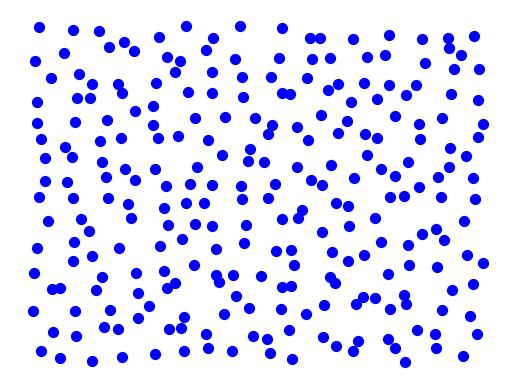

In [7]:


# # Example graph data
# G = {
#     'N': 10,  # Number of nodes
#     'Ne': 15,  # Number of edges
#     'A': np.random.randint(0, 2, (10, 10)),  # Random adjacency matrix
#     'coords': np.random.rand(10, 2),  # Random 2D coordinates
#     'plotting': {
#         'vertex_color': 'b',
#         'vertex_size': 50
#     },
#     'vertex_color': 'r'
# }

# # Optional parameters
# param = {
#     'show_edges': True,
#     'clear': True,
#     'edge_size': 1
# }

# # Plot the graph
# gsp_plot_graph(G, param)
def gsp_isdirected(G):
    import numpy as np
    from scipy.sparse import issparse, csr_matrix

    if isinstance(G, dict):
        W = G['W']
    else:
        W = G

    # Increase numerical tolerance
    epsilon = 1e-9  # Adjusted tolerance

    if issparse(W):
        W = W.tocsr()
        W_transpose = W.transpose().tocsr()
        diff = W - W_transpose
        abs_diff = diff.copy()
        abs_diff.data = np.abs(abs_diff.data)
        abs_diff.data[abs_diff.data <= epsilon] = 0
        abs_diff.eliminate_zeros()
        is_directed = abs_diff.nnz > 0
    else:
        W = np.array(W)
        abs_diff = np.abs(W - W.T)
        is_directed = np.any(abs_diff > epsilon)

    return is_directed
import numpy as np
import matplotlib.pyplot as plt

# Reset the random seed
np.random.seed(1)

# Create a 2D grid graph of size 16x16
G = gsp_2dgrid(16)

# Number of nodes
n = G['N']

# Original weight matrix
W0 = G['W']

# Add noise to the coordinates
coords_noisy = G['coords'] + 0.05 * np.random.rand(*G['coords'].shape)

# Create a new graph with the noisy coordinates
G = gsp_graph(G['W'], coords=coords_noisy)

# Plot the graph
plt.figure()
gsp_plot_graph(G)
plt.show()

In [8]:
def gsp_nn_distanz(X1, X2=None, param=None):
    """
    Compute the nearest neighbor distances.

    Parameters:
        X1 (numpy.ndarray): Input points 1 of shape (n_features, n_samples)
        X2 (numpy.ndarray, optional): Input points 2 of shape (n_features, n_samples). Defaults to X1.
        param (dict, optional): Structure of optional parameters.

    Returns:
        indx (numpy.ndarray): Indices over x
        indy (numpy.ndarray): Indices over y
        dist (numpy.ndarray): Distances
        Xo1 (numpy.ndarray): Points 1 after rescaling
        Xo2 (numpy.ndarray): Points 2 after rescaling
        epsilon (float): Radius of the ball (if the ball is used)
        NN (numpy.ndarray or list): Indices of closest neighbours of each node
        Dist (numpy.ndarray or list): Sorted distances for each node
    """

    if param is None:
        param = {}

    if X2 is None:
        X2 = X1

    defaults = {
        'type': 'knn',
        'use_flann': 0,
        'use_full': 0,
        'center': 1,
        'rescale': 0,
        'k': 10,
        'epsilon': 0.01,
        'use_l1': 0,
        'use_cosine': 0,
        'target_degree': 0,
        'flann_nbcores': 1,
        'flann_checks': 256
    }

    for key, value in defaults.items():
        param.setdefault(key, value)

    X1 = np.array(X1)
    X2 = np.array(X2)

    n_features, n1 = X1.shape
    n_features2, n2 = X2.shape

    if n_features != n_features2:
        raise ValueError('X1 and X2 must have the same number of features')

    if param['type'].lower() == 'knn' and param['k'] > n1:
        raise ValueError('Not enough samples')

    # Concatenate X1 and X2, and transpose to get (n_samples_total, n_features)
    Xo = np.hstack([X1, X2]).T  # shape (n_samples_total, n_features)

    Nel, Nfeatures = Xo.shape

    # Center the data
    if param['center']:
        Xo = Xo - np.mean(Xo, axis=0)

    # Rescale the data
    if param['rescale']:
        bounding_radius = 0.5 * np.linalg.norm(np.max(Xo, axis=0) - np.min(Xo, axis=0))
        scale = np.power(Nel, 1.0 / min(Nfeatures, 3)) / 10
        Xo = Xo * (scale / bounding_radius)

    # Split back into Xo1 and Xo2
    Xo1 = Xo[:n1, :]
    Xo2 = Xo[n1:(n1 + n2), :]

    if param['use_full']:
        # Compute full distance matrix
        if param['use_l1']:
            metric = 'cityblock'
        elif param['use_cosine']:
            metric = 'cosine'
        else:
            metric = 'euclidean'

        D = cdist(Xo1, Xo2, metric=metric)  # D has shape (n1, n2)

        if param['type'].lower() == 'knn':
            ind = np.argsort(D, axis=0)  # indices of sorted distances
            Ds = np.sort(D, axis=0)

            indx = ind[:param['k'], :].flatten()  # indices in Xo1
            indy = np.repeat(np.arange(n2), param['k'])  # indices in Xo2
            dist = Ds[:param['k'], :].flatten()
            epsilon = np.nan
            # For outputs NN and Dist
            NN = ind[:param['k'], :].T  # shape (n2, k)
            Dist = Ds[:param['k'], :].T  # shape (n2, k)

        elif param['type'].lower() == 'radius':
            D_mask = D <= param['epsilon']
            indx, indy = np.nonzero(D_mask)
            dist = D[indx, indy]
            epsilon = param['epsilon']
            NN = None
            Dist = None
        else:
            raise ValueError('Unknown type: allowed values are knn, radius')

    else:
        # Do not compute full distance matrix

        if param['use_l1']:
            metric = 'manhattan'
        elif param['use_cosine']:
            metric = 'cosine'
            warnings.warn('Cosine distance NN graph uses an exhaustive search.')
        else:
            metric = 'euclidean'

        if param['type'].lower() == 'knn':

            if param['use_flann']:
                try:
                    # Prepare the data for pynndescent
                    index = pynndescent.NNDescent(
                        Xo1,
                        metric=metric,
                        n_jobs=param['flann_nbcores'],
                        n_neighbors=param['k'] + 1  # +1 because pynndescent includes the point itself
                    )
                    NN_array, Dist_array = index.query(
                        Xo2,
                        k=param['k']
                    )
                    NN = NN_array
                    Dist = Dist_array
                except ImportError:
                    warnings.warn('pynndescent not available, using exact search.')
                    param['use_flann'] = 0

            if not param['use_flann']:
                nbrs = NearestNeighbors(
                    n_neighbors=param['k'],
                    algorithm='auto',
                    metric=metric,
                    n_jobs=param['flann_nbcores']
                )
                nbrs.fit(Xo1)
                Dist, NN = nbrs.kneighbors(Xo2)  # Dist and NN have shape (n2, k)

            # Process NN and Dist to get indx, indy, dist
            indx = NN.flatten()  # indices in Xo1
            indy = np.repeat(np.arange(n2), param['k'])  # indices in Xo2
            dist = Dist.flatten()
            epsilon = np.nan

        elif param['type'].lower() == 'radius':

            if param['use_l1']:
                metric = 'manhattan'
            elif param['use_cosine']:
                metric = 'cosine'
                warnings.warn('Cosine distance NN graph uses an exhaustive search.')
            else:
                metric = 'euclidean'

            if param['use_flann']:
                warnings.warn('Approximate radius search is not supported with pynndescent, using exact search.')
                param['use_flann'] = 0

            if param['target_degree'] == 0:
                epsilon = param['epsilon']
            else:
                target_d = int(np.floor(param['target_degree']))
                nbrs = NearestNeighbors(
                    n_neighbors=target_d,
                    algorithm='auto',
                    metric=metric,
                    n_jobs=param['flann_nbcores']
                )
                nbrs.fit(Xo1)
                Dist_k, NN_k = nbrs.kneighbors(Xo2)
                avg_d = np.mean(Dist_k[:, -1])  # Average distance to the 'target_d'-th neighbor
                epsilon = avg_d

            # Now proceed to find neighbors within epsilon
            nbrs = NearestNeighbors(
                radius=epsilon,
                algorithm='auto',
                metric=metric,
                n_jobs=param['flann_nbcores']
            )
            nbrs.fit(Xo1)
            Dist_array = nbrs.radius_neighbors(Xo2, return_distance=True)

            # Collect indices and distances
            indx = []
            indy = []
            dist = []

            for i in range(n2):
                dists_i = Dist_array[0][i]
                nn_i = Dist_array[1][i]
                indx.extend(nn_i)
                indy.extend([i] * len(nn_i))
                dist.extend(dists_i)

            indx = np.array(indx)
            indy = np.array(indy)
            dist = np.array(dist)
            NN = Dist_array[1]
            Dist = Dist_array[0]

        else:
            raise ValueError('Unknown type: allowed values are knn, radius')

    # Transpose Xo1 and Xo2 back to shape (n_features, n_samples)
    Xo1 = Xo1.T  # shape (n_features, n1)
    Xo2 = Xo2.T  # shape (n_features, n2)


    return indx, indy, dist, Xo1, Xo2, epsilon, NN, Dist



In [9]:

def gsp_symmetrize(W, type='full'):
    """
    Symmetrize a square matrix.

    Parameters:
        W (numpy.ndarray): Square matrix to symmetrize.
        type (str, optional): Type of symmetrization. Default is 'full'.

    Returns:
        numpy.ndarray: Symmetrized matrix.

    The available symmetrization types are:
    - 'average': Average of W and W.T
    - 'full': Copy the missing entries by taking the maximum between W and W.T
    - 'none': Do nothing (the matrix might stay asymmetric)
    """

    if type == 'average':
        W = (W + W.T) / 2
    elif type == 'full':
        W = np.maximum(W, W.T)
    elif type == 'none':
        pass  # Do nothing
    else:
        raise ValueError("gsp_symmetrize: Unknown type")
    return W

In [10]:


def gsp_compute_theta_bounds(Z, geom_mean=0, is_sorted=False):
    """
    Compute the values of parameter theta (controlling sparsity) that should
    be expected to give each sparsity level. Return upper and lower bounds 
    for each sparsity level k = [1, ..., n-1] neighbors per node.

    Parameters:
        Z (numpy.ndarray): Zero-diagonal pairwise distance matrix between nodes (n x n).
        geom_mean (int, optional): Use geometric mean instead of arithmetic mean? Default is 0.
        is_sorted (bool, optional): Is Z already sorted? Default is False.

    Returns:
        theta_l (numpy.ndarray): Lower bounds for theta (length n-1).
        theta_u (numpy.ndarray): Upper bounds for theta (length n-1).
        Z_sorted (numpy.ndarray): Sorted distances (n x n-1).

    Notes:
        - The function assumes that Z is a symmetric matrix with zeros on the diagonal,
          representing pairwise distances between nodes.
        - If `geom_mean` is set to 1, the geometric mean is used instead of the arithmetic mean.
        - If `is_sorted` is True, Z is assumed to be already sorted appropriately.
    """
    # Check if Z is a matrix
    if not isinstance(Z, np.ndarray) or Z.ndim != 2:
        raise ValueError("Z must be a 2D numpy array")

    n = Z.shape[0]

    if is_sorted:
        Z_sorted = Z
    else:
        # Initialize Z_sorted with zeros
        Z_sorted = np.zeros((n, n - 1))
        for i in range(n):
            # Exclude the diagonal element Z[i, i]
            idx = np.concatenate((np.arange(0, i), np.arange(i + 1, n)))
            Z_row = Z[i, idx]
            # Sort the distances in ascending order
            Z_sorted[i, :] = np.sort(Z_row)
    
    m, n_cols = Z_sorted.shape  # m = n, n_cols = n - 1

    # Compute cumulative sums of sorted distances along each row
    B_k = np.cumsum(Z_sorted, axis=1)  # Shape: (n, n-1)
    
    # Create a matrix where each row is [1, 2, ..., n-1]
    K_mat = np.tile(np.arange(1, n_cols + 1), (m, 1))  # Shape: (n, n-1)

    # Compute C = K_mat * Z_sorted^2 - B_k * Z_sorted
    C = K_mat * (Z_sorted ** 2) - B_k * Z_sorted

    # Set invalid values (C <= 0) to NaN to avoid sqrt of negative numbers
    C[C <= 0] = np.nan

    # Compute theta_u using arithmetic or geometric mean
    if geom_mean == 0:
        theta_u = np.nanmean(1.0 / np.sqrt(C), axis=0)
    else:
        theta_u = np.exp(np.nanmean(np.log(1.0 / np.sqrt(C)), axis=0))

    # Replace NaN in theta_u with zeros
    theta_u = np.nan_to_num(theta_u, nan=0.0)

    # Compute theta_l by shifting theta_u and appending zero
    theta_l = np.append(theta_u[1:], 0)

    return theta_l, theta_u, Z_sorted


def gsp_compute_graph_learning_theta(Z, k, geom_mean=0, is_sorted=False):
    """
    Compute the value of parameter theta for graph learning that corresponds to a desired sparsity level k.

    Parameters:
        Z (numpy.ndarray): Zero-diagonal pairwise distance matrix between nodes (n x n).
        k (int): Desired sparsity level (number of neighbors per node).
        geom_mean (int, optional): Use geometric mean instead of arithmetic mean? Default is 0.
        is_sorted (bool, optional): Is Z already sorted? Default is False.

    Returns:
        theta (float): Computed theta value for the desired sparsity level k.
        theta_min (float): Lower bound of theta for sparsity level k.
        theta_max (float): Upper bound of theta for sparsity level k.

    Notes:
        - This function relies on gsp_compute_theta_bounds.
        - The function assumes that Z is a symmetric matrix with zeros on the diagonal.
    """
    # Compute theta bounds
    theta_l, theta_u, Z_sorted = gsp_compute_theta_bounds(Z, geom_mean, is_sorted)
    
    # Adjust indices for 0-based indexing in Python
    theta_min = theta_l[k - 1]  # theta_l corresponds to theta_min
    theta_max = theta_u[k - 1]  # theta_u corresponds to theta_max
    
    # Compute theta
    if k > 1:
        theta = np.sqrt(theta_min * theta_max)
    else:
        theta = theta_min * 1.1  # Slightly adjust theta for k=1
    
    return theta, theta_min, theta_max

In [11]:
import numpy as np

# Assume that gsp_compute_theta_bounds is defined as per the previous translation.

# Example pairwise distance matrix Z (zero-diagonal)
Z = np.array([
    [0, 1.2, 0.5, 2.3],
    [1.2, 0, 1.5, 0.8],
    [0.5, 1.5, 0, 1.1],
    [2.3, 0.8, 1.1, 0]
])

# Ensure Z is symmetric and zero-diagonal
Z = (Z + Z.T) / 2
np.fill_diagonal(Z, 0)

# Desired sparsity level (number of neighbors per node)
k = 2

# Compute theta
theta, theta_min, theta_max = gsp_compute_graph_learning_theta(Z, k)

print("Computed theta for sparsity level k =", k, "is:", theta)
print("Theta lower bound (theta_min):", theta_min)
print("Theta upper bound (theta_max):", theta_max)

Computed theta for sparsity level k = 2 is: 0.8887105806528117
Theta lower bound (theta_min): 0.5737624658884569
Theta upper bound (theta_max): 1.376539148376083


/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_21057/3454056787.py:57: RuntimeWarning: Mean of empty slice
  theta_u = np.nanmean(1.0 / np.sqrt(C), axis=0)


In [12]:
import numpy as np

# Generate sample data
X1 = np.random.rand(3, 100)  # 100 samples with 3 features
X2 = np.random.rand(3, 50)   # 50 samples with 3 features

# Define parameters
param = {
    'type': 'knn',
    'k': 5,
    'use_flann': 1,  # Set to 1 to use pynndescent for approximate NN
    'use_l1': 0,
    'flann_nbcores': -1  # Use all available cores
}

# Call the function
indx, indy, dist, Xo1, Xo2, epsilon, NN, Dist = gsp_nn_distanz(X1, X2, param)

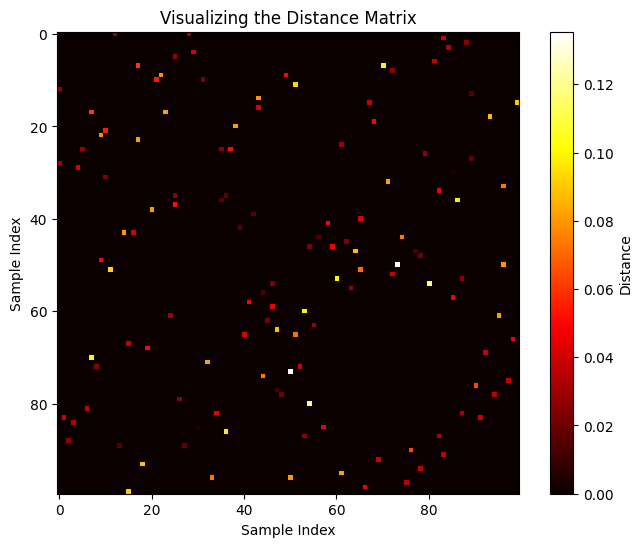

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

# Assume gsp_nn_distanz is already defined as per the previous code.
# If not, please ensure you've defined it in your environment.

# 1. Generate sample data
n_features = 2
n_samples = 100  # Number of samples

# Create random data points
np.random.seed(0)  # For reproducibility
X = np.random.rand(n_features, n_samples)

# 2. Define parameters for nearest neighbor search
param = {
    'type': 'knn',       # Type of neighbor search ('knn' or 'radius')
    'k': 2,             # Number of nearest neighbors
    'use_flann': 1,      # Use approximate NN search with pynndescent
    'use_l1': 0,         # Use Euclidean distance
    'center': 1,         # Center the data
    'rescale': 0,        # Do not rescale the data
    'use_full': 0,       # Do not compute full distance matrix
    'flann_nbcores': -1  # Use all available CPU cores
}

# 3. Compute nearest neighbors
indx, indy, dist, Xo1, Xo2, epsilon, NN, Dist = gsp_nn_distanz(X, param=param)

# 4. Reconstruct the distance matrix
# Since we're dealing with a single dataset, X1 = X2 = X
n_samples = X.shape[1]

# Create a sparse distance matrix from the outputs
# Note: indx and indy are indices over X1 and X2, respectively.
# Since X1 = X2, we can create a square matrix of size (n_samples, n_samples)
distance_matrix_sparse = coo_matrix((dist, (indx, indy)), shape=(n_samples, n_samples))

# Convert the sparse matrix to a dense format for visualization
distance_matrix_dense = distance_matrix_sparse.toarray()

# Since the distance matrix may be asymmetric due to the way indices are collected,
# we can symmetrize it if desired
distance_matrix_symmetric = np.maximum(distance_matrix_dense, distance_matrix_dense.T)

# 5. Visualize the distance matrix
plt.figure(figsize=(8, 6))
plt.imshow(distance_matrix_symmetric, cmap='hot', interpolation='nearest')
plt.colorbar(label='Distance')
plt.title('Visualizing the Distance Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.show()

In [22]:
np.sum(np.diag(distance_matrix_symmetric))

0.0

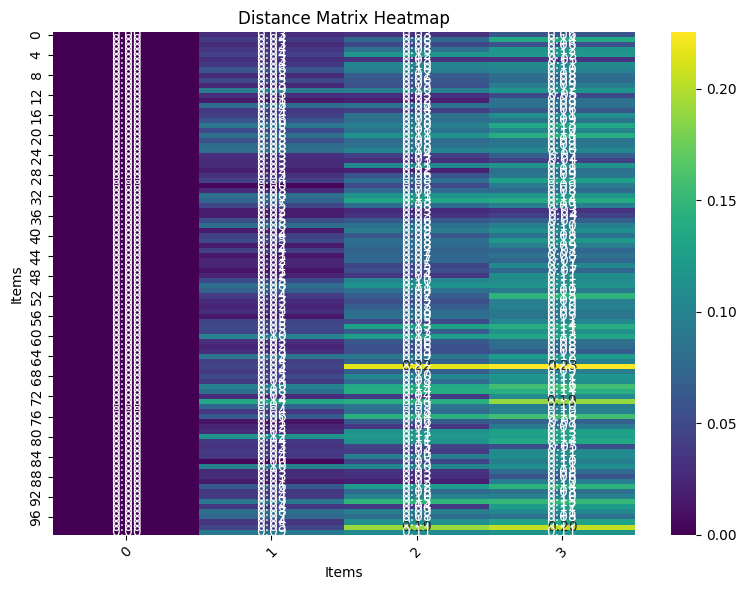

In [19]:
# Create the heatmap
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(Dist, annot=True, fmt=".2f", cmap='viridis')
plt.title('Distance Matrix Heatmap')
plt.xlabel('Items')
plt.ylabel('Items')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()

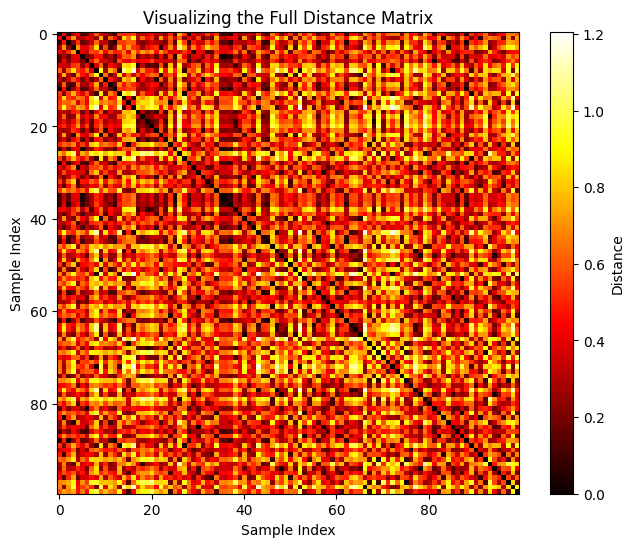

In [20]:
# Update parameters to compute full distance matrix
param['use_full'] = 1

# Compute the full distance matrix
indx, indy, dist, Xo1, Xo2, epsilon, NN, Dist = gsp_nn_distanz(X, param=param)

# Assuming D is the full distance matrix (n_samples x n_samples)

# Recompute D for visualization purposes
D = cdist(Xo1.T, Xo2.T, metric='euclidean')

# Visualize the full distance matrix
plt.figure(figsize=(8, 6))
plt.imshow(D, cmap='hot', interpolation='nearest')
plt.colorbar(label='Distance')
plt.title('Visualizing the Full Distance Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.show()

In [107]:
import numpy as np
import scipy.sparse as sp
import time
import matplotlib.pyplot as plt

# Ensure 'k' is defined (desired number of neighbors per node)
k = 5  # Set k to your desired number of neighbors

# Ensure 'X' is defined and has the correct shape
# X should be of shape (n_samples, n_features)
# For this example, let's create dummy data
n_samples = 100
n_features = 2
X = np.random.rand(n_samples, n_features)

# Ensure X has shape (n_samples, n_features)
if X.shape[0] < X.shape[1]:
    X = X.T
print('Shape of X:', X.shape)

n = X.shape[0]  # Number of nodes
print('Number of nodes (n):', n)

# We compute an approximate Nearest Neighbors graph
# Using sklearn's NearestNeighbors as an equivalent to FLANN
from sklearn.neighbors import NearestNeighbors

params_NN = {}
params_NN['k'] = 2 * k + 1  # Approximately double the number of edges

# Start timing the nearest neighbors computation
clock_flann = time.time()

# Compute approximate nearest neighbors
nbrs = NearestNeighbors(n_neighbors=params_NN['k'], algorithm='auto').fit(X)
distances, indices = nbrs.kneighbors(X)

# Prepare indx, indy, dist
indx = np.repeat(np.arange(n), params_NN['k'])
indy = indices.flatten()
dist = distances.flatten()

# Stop timing and compute elapsed time
time_flann = time.time() - clock_flann
print(f'Time for Nearest Neighbors: {time_flann:.3f} seconds')

# Verify indices are within bounds
print('Index ranges:')
print('indx:', indx.min(), 'to', indx.max())
print('indy:', indy.min(), 'to', indy.max())
print('Number of nodes (n):', n)
assert indx.min() >= 0 and indx.max() < n, f"Indices in indx are out of bounds: {indx.min()} to {indx.max()}"
assert indy.min() >= 0 and indy.max() < n, f"Indices in indy are out of bounds: {indy.min()} to {indy.max()}"

# Square the distances
dist_squared = dist ** 2

# Create a sparse matrix of squared distances
Z_sp = sp.csr_matrix((dist_squared, (indx, indy)), shape=(n, n))

Z_sp = gsp_symmetrize(Z_sp)

# Remove the first column that corresponds to zero distances (each node to itself)
Z_sorted = np.sort(distances, axis=1)[:, 1:] ** 2  # First column is zero distance to self

# Indicate that distances are sorted
Z_is_sorted = True

theta, theta_min, theta_max = gsp_compute_graph_learning_theta(Z_sorted, k, geom_mean=0, is_sorted=Z_is_sorted)

# Set up parameters for graph learning
params = {}
params['edge_mask'] = Z_sp > 0  # Edge mask where distances are positive
params['fix_zeros'] = 1

# Multiply Z_sp by theta
Z_sp_theta = Z_sp.multiply(theta)

W3, info_3 = gsp_learn_graph_log_degrees(Z_sp_theta, alpha=1, beta=1, params=params)

# Set small weights to zero to enforce sparsity
W3.data[W3.data < 1e-4] = 0
W3.eliminate_zeros()

# For demonstration, we'll set W and W2 to be W3
W = W3.copy()
W2 = W3.copy()

# Compute the relative difference between two solutions
rel_diff = np.linalg.norm(W.toarray() - W2.toarray(), 'fro') / np.linalg.norm(W.toarray(), 'fro')
print(f'Relative difference between two solutions: {rel_diff:.4f}')

# Plot the sparsity patterns of W3 and the edge mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.spy(W3, markersize=1)
plt.title('W_3')

plt.subplot(1, 2, 2)
plt.spy(params['edge_mask'], markersize=1)
plt.title('Edge Mask')

plt.show()

Shape of X: (100, 2)
Number of nodes (n): 100
Time for Nearest Neighbors: 0.002 seconds
Index ranges:
indx: 0 to 99
indy: 0 to 99
Number of nodes (n): 100


/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_9157/183716707.py:21: SparseEfficiencyWarning: Comparing sparse matrices using >= and <= is inefficient, using <, >, or !=, instead.
  W = np.maximum(W, W.T)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().